In [1]:
import pathlib
import tempfile
import zipfile

import geopandas
import pystac
import stac2dcache
import urlpath

from shapely.geometry import Polygon
from stac2dcache.utils import get_asset

from eratosthenes.preprocessing.handler_multispec import get_shadow_bands
from eratosthenes.preprocessing.shadow_transforms import enhance_shadow
from eratosthenes.preprocessing.shadow_geometry import shadow_image_to_list, create_shadow_polygons
from eratosthenes.generic.mapping_io import makeGeoIm

# Generate shadow-enhanced images

In [2]:
catalog_url = ("https://webdav.grid.surfsara.nl:2880"
               "/pnfs/grid.sara.nl/data/eratosthenes/"
               "disk/red-glacier_sentinel-2")
collection_id = "sentinel-s2-l1c"

In [3]:
# configure connection to dCache
dcache = stac2dcache.configure(
    filesystem="dcache", 
    token_filename="macaroon.dat"
)
# dcache.api_url = "https://dcacheview.grid.surfsara.nl:22880/api/v1"

In [4]:
def read_catalog(url):
    """
    Read STAC catalog from URL
    
    :param url: urlpath to the catalog root
    :return: PySTAC Catalog object
    """
    url = url if url.endswith("catalog.json") else f"{url}/catalog.json"
    catalog = pystac.Catalog.from_file(url)
    return catalog

In [5]:
# read image catalog
catalog = read_catalog(catalog_url)
subcatalog = catalog.get_child(collection_id)

In [6]:
# TILE_ID_KEYS = [
#     "sentinel:utm_zone", 
#     "sentinel:latitude_band", 
#     "sentinel:grid_square"
# ] 
# def get_sentinel2_tile_id(item):
#     """
#     Construct the tile ID for a Sentinel-2 STAC item
    
#     :param item: PySTAC Item object
#     :return: tile ID
#     """
#     return "".join([
#         str(item.properties[k]) for k in TILE_ID_KEYS
#     ])

In [7]:
items = catalog.get_all_items()

In [8]:
item = next(items)
item

<Item id=S2B_5VMG_20210329_0_L1C>

In [9]:
item.properties

{'datetime': '2021-03-29T21:58:42Z',
 'platform': 'sentinel-2b',
 'constellation': 'sentinel-2',
 'instruments': ['msi'],
 'gsd': 10,
 'view:off_nadir': 0,
 'proj:epsg': 32605,
 'sentinel:utm_zone': 5,
 'sentinel:latitude_band': 'V',
 'sentinel:grid_square': 'MG',
 'sentinel:sequence': '0',
 'sentinel:product_id': 'S2B_MSIL1C_20210329T215529_N0209_R029_T05VMG_20210329T223033',
 'sentinel:data_coverage': 20.11,
 'eo:cloud_cover': 99.99,
 'created': '2021-03-30T07:38:41.779Z',
 'updated': '2021-03-30T07:38:41.779Z'}

In [10]:
bands = get_shadow_bands(collection_id)
asset_keys = [f"B{b:02}" for b in bands]

assets = []
for asset_key in asset_keys:
    assets.append(
        get_asset(
            catalog,
            asset_key=asset_key,
            item_id=item.id,
            filesystem=dcache
        )
    )

In [11]:
shadow_transform = "ruffenacht"

In [12]:
metadata = get_asset(
    catalog,
    asset_key='metadata',
    item_id=item.id,
    filesystem=dcache
)
with open("MTD_TL.xml", 'w') as f:
    f.write(metadata)

In [13]:
crs = assets[0].spatial_ref.crs_wkt
transform = assets[0].rio.transform()
B, G, R, NIR = (a.squeeze().data for a in assets)
shadow = enhance_shadow(
    shadow_transform, Blue=B, Green=G, Red=R, Nir=NIR, RedEdge=None, Shw=None
)

In [14]:
output_file = f"{item.id}_shadow.tif"
makeGeoIm(
    shadow, transform.to_gdal(), crs, output_file,
    meta_descr=shadow_transform, 
    date_created=item.datetime.strftime("%Y:%m:%d %H:%M:%S")
)

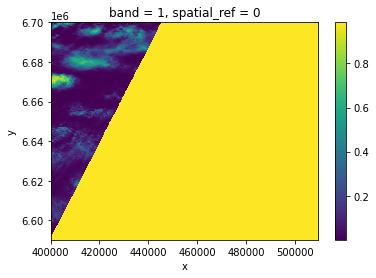

In [15]:
import rioxarray as rioxr
da = rioxr.open_rasterio(output_file)
da.squeeze().plot.imshow()

In [16]:
shadow_image_to_list(
    shadow, transform.to_gdal(), "./", {'bbox': None}
)

In [17]:
(labels, cast_conn) = create_shadow_polygons(shadow, "./")

For shadowpolygon #1: Its size is 18 by 51, connecting 68 pixels in total
polygon done
For shadowpolygon #2: Its size is 10979 by 10979, connecting 21955 pixels in total
polygon done
For shadowpolygon #3: Its size is 12 by 8, connecting 14 pixels in total
polygon done
For shadowpolygon #4: Its size is 10 by 9, connecting 10 pixels in total
polygon done
For shadowpolygon #5: Its size is 34 by 55, connecting 68 pixels in total
polygon done
For shadowpolygon #6: Its size is 23 by 39, connecting 49 pixels in total
polygon done
For shadowpolygon #7: Its size is 458 by 759, connecting 1743 pixels in total
polygon done
For shadowpolygon #8: Its size is 5 by 10, connecting 10 pixels in total
polygon done
For shadowpolygon #9: Its size is 3 by 3, connecting 2 pixels in total
polygon done
For shadowpolygon #10: Its size is 12 by 5, connecting 13 pixels in total
polygon done
For shadowpolygon #11: Its size is 33 by 36, connecting 47 pixels in total
polygon done
For shadowpolygon #12: Its size is 

In [18]:
output_file = f"{item.id}_polygons.tif"
makeGeoIm(
    labels, transform.to_gdal(), crs, output_file, no_dat=-9999,
    date_created=item.datetime.strftime("%Y:%m:%d %H:%M:%S")
)

In [19]:
output_file = f"{item.id}_castconn.tif"
makeGeoIm(
    cast_conn, transform.to_gdal(), crs, output_file, no_dat=-9999,
    date_created=item.datetime.strftime("%Y:%m:%d %H:%M:%S")
)

In [18]:
shadows_catalog = pystac.Catalog(
    id="red-glacier_sentinel-2_shadows",
    description=("Shadow enhanced Sentinel-2 tiles "
                 "for the Red Glacier (Alaska)")
)

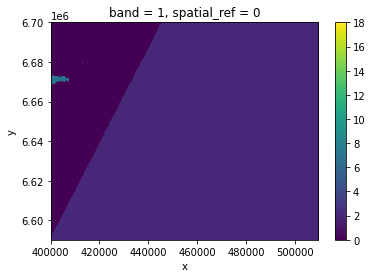

In [21]:
output_file = f"{item.id}_polygons.tif"
da = rioxr.open_rasterio(output_file)
da.squeeze().plot.imshow()

In [77]:
# loop over identified tiles
with tempfile.TemporaryDirectory(dir=tmp_path) as tmpdir:
    
    local_path = pathlib.Path(tmpdir) 

    url = urlpath.URL(gshhs_url)
    remote_shp_path = pathlib.Path(url.path)
    remote_regex_path = remote_shp_path.with_suffix(".*")
    remote_paths = dcache.glob(remote_regex_path.as_posix())
    
    # get (all parts of) shapefile
    for remote_path in remote_paths:
        path = pathlib.Path(remote_path)
        dcache.download(
            path.as_posix(), 
            (local_path/path.name).as_posix()
        )
        
    local_shp_path = local_path/remote_shp_path.name
    gshhs = geopandas.read_file(local_shp_path)
        
    for tile_id, item in tiles.items():

        da = get_asset(
            catalog,
            asset_key="B02",
            item_id=item.id,
            filesystem=dcache,
            load=False
        )
        bbox = da.rio.bounds()
        crs = da.spatial_ref.crs_wkt
        transform = da.rio.transform()

        tile_geometry = Polygon.from_bounds(
            *da.rio.transform_bounds(gshhs.crs)
        )
        
        mask = gshhs.intersects(tile_geometry)
        gshhs_sub = gshhs[mask]
        res = gshhs_sub.intersection(tile_geometry)
        
        shape_utm = geopandas.GeoDataFrame(
            dict(
                land=[1], 
                geometry=[res.to_crs(crs).unary_union]
            ), 
            crs=res.crs
        )
        local_shp_utm_path = local_shp_path.with_name(
            local_shp_path.stem + "_utm.shp"
        )
        shape_utm.to_file(local_shp_utm_path.as_posix())
        shape2raster(local_shp_utm_path.as_posix(), tile_id, transform.to_gdal(), 
                     da.y.size, da.x.size, aoi="land")

        # save raster file and upload it
        output_file = f"{tile_id}.tif"
        dcache.upload(output_file, f"{gshhs_tiles_url}/{output_file}")

GDAL headers saved to: /var/folders/t6/r2gjczqj7bb8798wr4g1p87m0000gn/T/tmpy6jtkan9
